In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
data_path = "/content/gdrive/My Drive/Data/"
model_path = "/content/gdrive/My Drive/Models/"

In [3]:
pip install transformers

     |████████████████████████████████| 1.4MB 5.8MB/s 
     |████████████████████████████████| 890kB 29.4MB/s 
     |████████████████████████████████| 2.9MB 40.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=3496070290a4569cc6baa18bfda2ab5edb65e42c2791fa73f314be6c30609101
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [4]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

In [5]:
RANDOM_SEED = 0
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
train_file = open(data_path + 'QC_train.txt')
test_file = open(data_path + 'QC_test.txt')

In [7]:
def get_df(inp_file):
  return pd.DataFrame(inp_file.readlines(), columns=['Question'])

In [8]:
train_data = get_df(train_file)
test_data = get_df(test_file)

In [9]:
train_data.head()

,Question
0,DESC:manner How did serfdom develop in and the...
1,ENTY:cremat What films featured the character ...
2,DESC:manner How can I find a list of celebriti...
3,ENTY:animal What fowl grabs the spotlight afte...
4,ABBR:exp What is the full form of .com ?\n


In [9]:
def improve_df(df):
  df['Type'] = df['Question'].apply(lambda s: s.split(' ', 1)[0])
  df['Question'] = df['Question'].apply(lambda s: s.split(' ', 1)[1])
  df['TypeSimple'] = df['Type'].apply(lambda s: s.split(':')[0])
  df['TypeExtended'] = df['Type'].apply(lambda s: s.split(':')[1])
  return df

In [10]:
train_data = improve_df(train_data)
test_data = improve_df(test_data)

In [12]:
train_data.head()

,Question,Type,TypeSimple,TypeExtended
0,How did serfdom develop in and then leave Russ...,DESC:manner,DESC,manner
1,What films featured the character Popeye Doyle...,ENTY:cremat,ENTY,cremat
2,How can I find a list of celebrities ' real na...,DESC:manner,DESC,manner
3,What fowl grabs the spotlight after the Chines...,ENTY:animal,ENTY,animal
4,What is the full form of .com ?\n,ABBR:exp,ABBR,exp


In [13]:
test_data.describe()

,Question,Type,TypeSimple,TypeExtended
count,500,500,500,500
unique,500,42,6,39
top,What color does litmus paper turn when it come...,DESC:def,DESC,def
freq,1,123,138,123


In [14]:
test_data.head()

,Question,Type,TypeSimple,TypeExtended
0,How far is it from Denver to Aspen ?\n,NUM:dist,NUM,dist
1,"What county is Modesto , California in ?\n",LOC:city,LOC,city
2,Who was Galileo ?\n,HUM:desc,HUM,desc
3,What is an atom ?\n,DESC:def,DESC,def
4,When did Hawaii become a state ?\n,NUM:date,NUM,date


In [15]:
train_data.append(test_data).describe()

,Question,Type,TypeSimple,TypeExtended
count,5952,5952,5952,5952
unique,5871,50,6,47
top,What is Columbia Tristar 's phone number ?\n,HUM:ind,ENTY,ind
freq,3,1017,1344,1017


In [11]:
TARGET_NAMES = train_data['TypeExtended'].unique().tolist()

In [12]:
from sklearn.preprocessing import LabelEncoder

In [13]:
def encode_tag(train_data, test_data, tag):
  l_enc = LabelEncoder()
  l_enc.fit(pd.Series(train_data[tag].tolist() + test_data[tag].tolist()).values)
  return l_enc.transform(train_data[tag].values), l_enc.transform(test_data[tag].values)

In [14]:
tag = 'Type'
train_data[tag], test_data[tag] = encode_tag(train_data, test_data, tag)
tag = 'TypeSimple'
train_data[tag], test_data[tag] = encode_tag(train_data, test_data, tag)
tag = 'TypeExtended'
train_data[tag], test_data[tag] = encode_tag(train_data, test_data, tag)

In [54]:
train_data.head()

,Question,Type,TypeSimple,TypeExtended
0,How did serfdom develop in and then leave Russ...,4,1,23
1,What films featured the character Popeye Doyle...,9,2,8
2,How can I find a list of celebrities ' real na...,4,1,23
3,What fowl grabs the spotlight after the Chines...,6,2,1
4,What is the full form of .com ?\n,1,0,16


In [55]:
train_data.columns

Index(['Question', 'Type', 'TypeSimple', 'TypeExtended'], dtype='object')

In [56]:
train_data['TypeExtended'].unique()

array([23,  8,  1, 16, 19, 18, 42, 11, 10, 32, 15, 36, 12,  6, 27, 22, 33,
       17,  7,  5, 41,  3,  2, 13, 25, 24, 31, 29, 37, 35, 30, 39, 44, 20,
        0, 34, 46, 21, 28,  4, 14, 40, 38, 26, 43, 45,  9])

In [15]:
SRC_COL = 'Question'
TRG_COL = 'TypeExtended'

In [16]:
TARGETS = train_data[TRG_COL].unique().tolist()
print(TARGETS)

[23, 8, 1, 16, 19, 18, 42, 11, 10, 32, 15, 36, 12, 6, 27, 22, 33, 17, 7, 5, 41, 3, 2, 13, 25, 24, 31, 29, 37, 35, 30, 39, 44, 20, 0, 34, 46, 21, 28, 4, 14, 40, 38, 26, 43, 45, 9]


In [17]:
TARGET_DICT = dict()
for i in range(len(TARGET_NAMES)):
  TARGET_DICT[TARGETS[i]] = TARGET_NAMES[i]

In [18]:
TARGET_DICT

{0: 'abb',
 1: 'animal',
 2: 'body',
 3: 'city',
 4: 'code',
 5: 'color',
 6: 'count',
 7: 'country',
 8: 'cremat',
 9: 'currency',
 10: 'date',
 11: 'def',
 12: 'desc',
 13: 'dismed',
 14: 'dist',
 15: 'event',
 16: 'exp',
 17: 'food',
 18: 'gr',
 19: 'ind',
 20: 'instru',
 21: 'lang',
 22: 'letter',
 23: 'manner',
 24: 'money',
 25: 'mount',
 26: 'ord',
 27: 'other',
 28: 'perc',
 29: 'period',
 30: 'plant',
 31: 'product',
 32: 'reason',
 33: 'religion',
 34: 'speed',
 35: 'sport',
 36: 'state',
 37: 'substance',
 38: 'symbol',
 39: 'techmeth',
 40: 'temp',
 41: 'termeq',
 42: 'title',
 43: 'veh',
 44: 'volsize',
 45: 'weight',
 46: 'word'}

In [20]:
BERT_MODEL_NAME = 'bert-base-cased' 

In [21]:
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [26]:
token_lengths = []
for sent in train_data[SRC_COL]:
  tokens = tokenizer.encode(sent, max_length=tokenizer.max_model_input_sizes[BERT_MODEL_NAME])
  token_lengths.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams

In [28]:
rcParams['figure.figsize'] = 8, 6

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Token count')

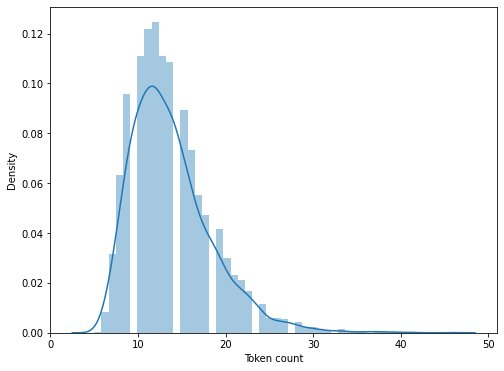

In [29]:
sns.distplot(token_lengths)
plt.xlim([0, tokenizer.max_model_input_sizes[BERT_MODEL_NAME] // 10])
plt.xlabel('Token count')

In [28]:
MAX_LEN = 32

In [31]:
class QuestionsDataset(Dataset):
  def __init__(self, src_list, trg_list, tokenizer, MAX_LEN):
    self.src_list = src_list
    self.trg_list = trg_list
    self.tokenizer = tokenizer
    self.MAX_LEN = MAX_LEN
  
  def __len__(self):
    return len(self.src_list)
  
  def __getitem__(self, item):
    src = str(self.src_list[item])
    trg = self.trg_list[item]
    encoder = tokenizer.encode_plus(
      src, add_special_tokens=True,
      max_length=self.MAX_LEN,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {'src': src, 'input_ids': encoder['input_ids'].flatten(), 'attention_mask': encoder['attention_mask'].flatten(), 'trg': torch.tensor(trg, dtype=torch.long)}

In [32]:
def get_loader(df, tokenizer, MAX_LEN, BATCH_SIZE):
  data = QuestionsDataset(src_list=df[SRC_COL].to_numpy(), trg_list=df[TRG_COL].to_numpy(), tokenizer=tokenizer, MAX_LEN=MAX_LEN)
  loader = DataLoader(data, batch_size=BATCH_SIZE)
  return loader

In [33]:
BATCH_SIZE = 32

train_loader = get_loader(train_data, tokenizer, MAX_LEN, BATCH_SIZE)
test_loader = get_loader(test_data, tokenizer, MAX_LEN, BATCH_SIZE)

In [34]:
data = next(iter(train_loader))
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['trg'].shape)

torch.Size([32, 32])
torch.Size([32, 32])
torch.Size([32])


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [22]:
bert = BertModel.from_pretrained(BERT_MODEL_NAME)

In [ ]:
res = bert(input_ids=data['input_ids'], attention_mask=data['attention_mask'])

In [ ]:
res[0].shape

torch.Size([32, 32, 768])

In [ ]:
res[1].shape

torch.Size([32, 768])

In [ ]:
after_lin = nn.Linear(bert.config.hidden_size, bert.config.hidden_size)(res[1])

In [ ]:
after_lin.shape

torch.Size([32, 768])

In [ ]:
nn.Linear(bert.config.hidden_size, len(TARGETS))(after_lin).shape

torch.Size([32, 47])

In [23]:
class Classifier(nn.Module):
  def __init__(self, bert, p, num_tags):
    super(Classifier, self).__init__()
    self.inp2emb = bert
    self.drop = nn.Dropout(p=p)
    self.emb2out = nn.Linear(self.inp2emb.config.hidden_size, num_tags)

  def forward(self, input_ids, attention_mask):
    emb = self.inp2emb(input_ids=input_ids, attention_mask=attention_mask)[1]
    emb = self.drop(emb)
    out = self.emb2out(emb)
    return out

In [24]:
classifier = Classifier(bert, 0.3, len(TARGETS))
classifier = classifier.to(device)

In [ ]:
EPOCHS = 10
optim = AdamW(classifier.parameters(), lr=2e-5)
crit = nn.CrossEntropyLoss().to(device)

In [ ]:
class ClassifierV2(nn.Module):
  def __init__(self, bert, p, num_tags):
    super(ClassifierV2, self).__init__()
    self.inp2emb = bert
    self.drop = nn.Dropout(p=p)
    self.emb2hid = nn.Linear(self.inp2emb.config.hidden_size, self.inp2emb.config.hidden_size)
    self.hid2out = nn.Linear(self.inp2emb.config.hidden_size, num_tags)

  def forward(self, input_ids, attention_mask):
    emb = self.inp2emb(input_ids=input_ids, attention_mask=attention_mask)[1]
    emb = self.drop(emb)
    hid = self.emb2hid(emb)
    out = self.hid2out(hid)
    return out

In [ ]:
classifierV2 = ClassifierV2(bert, 0.3, len(TARGETS))
classifierV2 = classifierV2.to(device)

In [ ]:
EPOCHS = 10
optim = AdamW(classifierV2.parameters(), lr=2e-5)
crit = nn.CrossEntropyLoss().to(device)

In [ ]:
class ClassifierV3(nn.Module):
  def __init__(self, bert, p, num_tags, hid_dim, num_lay):
    super(ClassifierV3, self).__init__()
    self.inp2emb = bert
    self.drop = nn.Dropout(p=p)
    self.emb2hid = nn.GRU(self.inp2emb.config.hidden_size, hid_dim, num_layers=num_lay, bidirectional=True, batch_first=True, dropout=p)
    self.hid2out = nn.Linear(hid_dim * 2, num_tags)

  def forward(self, input_ids, attention_mask):
    with torch.no_grad():
      emb = self.inp2emb(input_ids=input_ids, attention_mask=attention_mask)[0]
    h, hid = self.emb2hid(emb)
    hid = self.drop(torch.cat((hid[-2,:,:], hid[-1,:,:]), dim=1))
    out = self.hid2out(hid)
    return out

In [ ]:
classifierV3 = ClassifierV3(bert, 0.3, len(TARGETS), 256, 2)
classifierV3 = classifierV3.to(device)

In [ ]:
sum(p.numel() for p in classifierV3.parameters() if p.requires_grad)

111093039

In [ ]:
for name, param in classifierV3.named_parameters():
  if name.startswith('inp2emb'):
    param.requires_grad = False

In [ ]:
sum(p.numel() for p in classifierV3.parameters() if p.requires_grad)

2782767

In [ ]:
EPOCHS = 40
optim = AdamW(classifierV3.parameters(), lr=3e-5)
crit = nn.CrossEntropyLoss().to(device)

In [ ]:
class ClassifierV4(nn.Module):
  def __init__(self, bert, p, num_tags, hid_dim, num_lay):
    super(ClassifierV4, self).__init__()
    self.inp2emb = bert
    self.drop = nn.Dropout(p=p)
    self.emb2hid0 = nn.Linear(self.inp2emb.config.hidden_size, hid_dim * 2)
    self.emb2hid = nn.GRU(self.inp2emb.config.hidden_size, hid_dim, num_layers=num_lay, bidirectional=True, batch_first=True, dropout=p)
    self.hid2out = nn.Linear(hid_dim * 2, num_tags)

  def forward(self, input_ids, attention_mask):
    emb = self.inp2emb(input_ids=input_ids, attention_mask=attention_mask)
    hid0 = self.emb2hid0(emb[1])
    hid0 = torch.cat((hid0, hid0), dim=1).reshape(4, hid0.size(0), hid0.size(1) // 2)
    h, hid = self.emb2hid(emb[0], hid0)
    hid = self.drop(torch.cat((hid[-2,:,:], hid[-1,:,:]), dim=1))
    out = self.hid2out(hid)
    return out

In [ ]:
classifierV4 = ClassifierV4(bert, 0.3, len(TARGETS), 64, 2)
classifierV4 = classifierV4.to(device)

In [ ]:
EPOCHS = 10
optim = AdamW(classifierV4.parameters(), lr=2e-5)
crit = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(model, loader, crit, optim, device, num_ex):
  model = model.train()
  losses = []
  correct = 0

  for data in loader:
    input_ids = data['input_ids'].to(device)
    attention_mask = data['attention_mask'].to(device)
    trg = data['trg'].to(device)

    out = model(input_ids=input_ids, attention_mask=attention_mask)
    _, pred = torch.max(out, dim=1)
    loss = crit(out, trg)
    correct += torch.sum(pred == trg)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optim.step()
    optim.zero_grad()
  
  return correct.double() / num_ex, np.mean(losses)

In [39]:
def eval(model, loader, crit, device, num_ex):
  model = model.eval()
  losses = []
  correct = 0

  with torch.no_grad():
    for data in loader:
      input_ids = data['input_ids'].to(device)
      attention_mask = data['attention_mask'].to(device)
      trg = data['trg'].to(device)

      out = model(input_ids=input_ids, attention_mask=attention_mask)
      _, pred = torch.max(out, dim=1)
      loss = crit(out, trg)
      correct += torch.sum(pred == trg)
      losses.append(loss.item())
  
  return correct.double() / num_ex, np.mean(losses)

In [ ]:
name = 'QC_StandardExtended'
best_acc = 0

for epoch in range(EPOCHS):
  print('Epoch ', epoch + 1, '/', EPOCHS)
  print('-' * 10)
  
  train_acc, train_loss = train_epoch(classifier, train_loader, crit, optim, device, len(train_data))
  print('Train loss = ', train_loss, ' | Train acc = ', train_acc)
  
  val_acc, val_loss = eval(classifier, test_loader, crit, device, len(test_data))
  print('Val loss = ', val_loss, ' | Val acc = ', val_acc)

  if val_acc > best_acc:
    best_acc = val_acc
    torch.save(classifier.state_dict(), model_path + name + '.pt')

Epoch  1 / 10
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Train loss =  2.659545139262551  | Train acc =  tensor(0.3912, device='cuda:0', dtype=torch.float64)
Val loss =  1.6921062022447586  | Val acc =  tensor(0.6620, device='cuda:0', dtype=torch.float64)
Epoch  2 / 10
----------
Train loss =  1.1818803531384607  | Train acc =  tensor(0.7656, device='cuda:0', dtype=torch.float64)
Val loss =  0.9117884486913681  | Val acc =  tensor(0.8060, device='cuda:0', dtype=torch.float64)
Epoch  3 / 10
----------
Train loss =  0.5896115282997053  | Train acc =  tensor(0.8876, device='cuda:0', dtype=torch.float64)
Val loss =  0.7058103736490011  | Val acc =  tensor(0.8500, device='cuda:0', dtype=torch.float64)
Epoch  4 / 10
----------
Train loss =  0.3395491446319379  | Train acc =  tensor(0.9409, device='cuda:0', dtype=torch.float64)
Val loss =  0.5711104162037373  | Val acc =  tensor(0.8780, device='cuda:0', dtype=torch.float64)
Epoch  5 / 10
----------
Train loss =  0.19566298194491027  | Train acc =  tensor(0.9685, device='cuda:0', dtype=torch.float64

In [25]:
classifier.load_state_dict(torch.load(model_path + 'QC_StandardExtended.pt'))

<All keys matched successfully>

In [26]:
def classify(model, sent):
  encoded = tokenizer.encode_plus(sent, max_length=MAX_LEN, add_special_tokens=True, return_token_type_ids=False, pad_to_max_length=True, return_attention_mask=True, return_tensors='pt')
  input_ids = encoded['input_ids'].to(device)
  attention_mask = encoded['attention_mask'].to(device)

  out = model(input_ids, attention_mask)
  _, pred = torch.max(out, dim=1)

  return TARGET_DICT[pred.item()]

In [75]:
classify(classifier, 'What does NLP stand for ?')

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


'exp'

In [102]:
classify(classifier, 'What is the training strategy for recurrent neural networks ?')

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


'techmeth'

In [121]:
classify(classifier, 'What is the training strategy for athletes ?')

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


'desc'

In [129]:
classify(classifier, 'What is the name of this monitor model ?')

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


'product'

In [130]:
classify(classifier, 'What is the name of a company that produces this monitor model ?')

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


'gr'

In [100]:
classify(classifier, 'What is the highest point in the world ?')

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


'mount'

In [131]:
classify(classifier, 'What is the distance to the Moon ?')

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


'dist'

In [132]:
classify(classifier, 'How far is the Moon ?')

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


'dist'

In [134]:
classify(classifier, 'How fast is a sports car ?')

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


'speed'

In [135]:
classify(classifier, 'How expensive is a sports car ?')

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


'money'

In [30]:
classify(classifier, 'How to reveal the truth ?')

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


'manner'

In [ ]:
name = 'QC_V2Extended'
best_acc = 0

for epoch in range(EPOCHS):
  print('Epoch ', epoch + 1, '/', EPOCHS)
  print('-' * 10)
  
  train_acc, train_loss = train_epoch(classifierV2, train_loader, crit, optim, device, len(train_data))
  print('Train loss = ', train_loss, ' | Train acc = ', train_acc)
  
  val_acc, val_loss = eval(classifierV2, test_loader, crit, device, len(test_data))
  print('Val loss = ', val_loss, ' | Val acc = ', val_acc)

  if val_acc > best_acc:
    best_acc = val_acc
    torch.save(classifierV2.state_dict(), model_path + name + '.pt')

Epoch  1 / 10
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Train loss =  2.692896074021769  | Train acc =  tensor(0.3474, device='cuda:0', dtype=torch.float64)
Val loss =  1.8448433205485344  | Val acc =  tensor(0.6380, device='cuda:0', dtype=torch.float64)
Epoch  2 / 10
----------
Train loss =  1.3374563044274759  | Train acc =  tensor(0.7265, device='cuda:0', dtype=torch.float64)
Val loss =  1.1521113105118275  | Val acc =  tensor(0.7400, device='cuda:0', dtype=torch.float64)
Epoch  3 / 10
----------
Train loss =  0.7145932967725553  | Train acc =  tensor(0.8509, device='cuda:0', dtype=torch.float64)
Val loss =  0.8616854082792997  | Val acc =  tensor(0.8160, device='cuda:0', dtype=torch.float64)
Epoch  4 / 10
----------
Train loss =  0.41126967092965083  | Train acc =  tensor(0.9213, device='cuda:0', dtype=torch.float64)
Val loss =  0.7047843337059021  | Val acc =  tensor(0.8640, device='cuda:0', dtype=torch.float64)
Epoch  5 / 10
----------
Train loss =  0.24218887078701057  | Train acc =  tensor(0.9538, device='cuda:0', dtype=torch.float6

In [ ]:
name = 'QC_V2Extended'

for epoch in range(EPOCHS // 2):
  print('Epoch ', epoch + 1, '/', EPOCHS // 2)
  print('-' * 10)
  
  train_acc, train_loss = train_epoch(classifierV2, train_loader, crit, optim, device, len(train_data))
  print('Train loss = ', train_loss, ' | Train acc = ', train_acc)
  
  val_acc, val_loss = eval(classifierV2, test_loader, crit, device, len(test_data))
  print('Val loss = ', val_loss, ' | Val acc = ', val_acc)

  if val_acc > best_acc:
    best_acc = val_acc
    torch.save(classifierV2.state_dict(), model_path + name + '.pt')

Epoch  1 / 5
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Train loss =  0.015654575947688466  | Train acc =  tensor(0.9980, device='cuda:0', dtype=torch.float64)
Val loss =  0.5124211790971458  | Val acc =  tensor(0.9200, device='cuda:0', dtype=torch.float64)
Epoch  2 / 5
----------
Train loss =  0.014134246510132188  | Train acc =  tensor(0.9978, device='cuda:0', dtype=torch.float64)
Val loss =  0.5206314070383087  | Val acc =  tensor(0.9300, device='cuda:0', dtype=torch.float64)
Epoch  3 / 5
----------
Train loss =  0.008733684594650366  | Train acc =  tensor(0.9994, device='cuda:0', dtype=torch.float64)
Val loss =  0.5460166746634059  | Val acc =  tensor(0.9260, device='cuda:0', dtype=torch.float64)
Epoch  4 / 5
----------
Train loss =  0.00811946668664854  | Train acc =  tensor(0.9987, device='cuda:0', dtype=torch.float64)
Val loss =  0.5469755629892461  | Val acc =  tensor(0.9280, device='cuda:0', dtype=torch.float64)
Epoch  5 / 5
----------
Train loss =  0.00996241720334752  | Train acc =  tensor(0.9987, device='cuda:0', dtype=torch.flo

In [ ]:
name = 'QC_V3Extended'
best_acc = 0

for epoch in range(EPOCHS):
  print('Epoch ', epoch + 1, '/', EPOCHS)
  print('-' * 10)
  
  train_acc, train_loss = train_epoch(classifierV3, train_loader, crit, optim, device, len(train_data))
  print('Train loss = ', train_loss, ' | Train acc = ', train_acc)
  
  val_acc, val_loss = eval(classifierV3, test_loader, crit, device, len(test_data))
  print('Val loss = ', val_loss, ' | Val acc = ', val_acc)

  if val_acc > best_acc:
    best_acc = val_acc
    torch.save(classifierV3.state_dict(), model_path + name + '.pt')

Epoch  1 / 40
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Train loss =  3.2238857913435552  | Train acc =  tensor(0.1851, device='cuda:0', dtype=torch.float64)
Val loss =  3.0610771626234055  | Val acc =  tensor(0.1140, device='cuda:0', dtype=torch.float64)
Epoch  2 / 40
----------
Train loss =  2.855712820911965  | Train acc =  tensor(0.2744, device='cuda:0', dtype=torch.float64)
Val loss =  2.735644668340683  | Val acc =  tensor(0.4680, device='cuda:0', dtype=torch.float64)
Epoch  3 / 40
----------
Train loss =  2.5425728315498395  | Train acc =  tensor(0.4041, device='cuda:0', dtype=torch.float64)
Val loss =  2.3518204763531685  | Val acc =  tensor(0.4580, device='cuda:0', dtype=torch.float64)
Epoch  4 / 40
----------
Train loss =  2.2424894020571347  | Train acc =  tensor(0.4573, device='cuda:0', dtype=torch.float64)
Val loss =  2.0784351155161858  | Val acc =  tensor(0.5520, device='cuda:0', dtype=torch.float64)
Epoch  5 / 40
----------
Train loss =  2.0077856479332463  | Train acc =  tensor(0.4958, device='cuda:0', dtype=torch.float64)


In [ ]:
name = 'QC_V3Extended'

for epoch in range(EPOCHS):
  print('Epoch ', epoch + 1, '/', EPOCHS)
  print('-' * 10)
  
  train_acc, train_loss = train_epoch(classifierV3, train_loader, crit, optim, device, len(train_data))
  print('Train loss = ', train_loss, ' | Train acc = ', train_acc)
  
  val_acc, val_loss = eval(classifierV3, test_loader, crit, device, len(test_data))
  print('Val loss = ', val_loss, ' | Val acc = ', val_acc)

  if val_acc > best_acc:
    best_acc = val_acc
    torch.save(classifierV3.state_dict(), model_path + name + '.pt')

Epoch  1 / 40
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Train loss =  0.44032122660972917  | Train acc =  tensor(0.8795, device='cuda:0', dtype=torch.float64)
Val loss =  0.701655887067318  | Val acc =  tensor(0.8100, device='cuda:0', dtype=torch.float64)
Epoch  2 / 40
----------
Train loss =  0.4206294379039118  | Train acc =  tensor(0.8837, device='cuda:0', dtype=torch.float64)
Val loss =  0.6909708678722382  | Val acc =  tensor(0.8160, device='cuda:0', dtype=torch.float64)
Epoch  3 / 40
----------
Train loss =  0.40823520214585535  | Train acc =  tensor(0.8877, device='cuda:0', dtype=torch.float64)
Val loss =  0.680126715451479  | Val acc =  tensor(0.8160, device='cuda:0', dtype=torch.float64)
Epoch  4 / 40
----------
Train loss =  0.3967539683768624  | Train acc =  tensor(0.8947, device='cuda:0', dtype=torch.float64)
Val loss =  0.6733808219432831  | Val acc =  tensor(0.8200, device='cuda:0', dtype=torch.float64)
Epoch  5 / 40
----------
Train loss =  0.38055880999530267  | Train acc =  tensor(0.8967, device='cuda:0', dtype=torch.float6

In [ ]:
name = 'QC_V4Extended'
best_acc = 0

for epoch in range(EPOCHS):
  print('Epoch ', epoch + 1, '/', EPOCHS)
  print('-' * 10)
  
  train_acc, train_loss = train_epoch(classifierV4, train_loader, crit, optim, device, len(train_data))
  print('Train loss = ', train_loss, ' | Train acc = ', train_acc)
  
  val_acc, val_loss = eval(classifierV4, test_loader, crit, device, len(test_data))
  print('Val loss = ', val_loss, ' | Val acc = ', val_acc)

  if val_acc > best_acc:
    best_acc = val_acc
    torch.save(classifierV4.state_dict(), model_path + name + '.pt')

Epoch  1 / 10
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Train loss =  2.745063591421696  | Train acc =  tensor(0.4486, device='cuda:0', dtype=torch.float64)
Val loss =  1.8576382100582123  | Val acc =  tensor(0.6740, device='cuda:0', dtype=torch.float64)
Epoch  2 / 10
----------
Train loss =  1.623408089255729  | Train acc =  tensor(0.7915, device='cuda:0', dtype=torch.float64)
Val loss =  1.3350325599312782  | Val acc =  tensor(0.7900, device='cuda:0', dtype=torch.float64)
Epoch  3 / 10
----------
Train loss =  1.1152389934885572  | Train acc =  tensor(0.8863, device='cuda:0', dtype=torch.float64)
Val loss =  1.0590244680643082  | Val acc =  tensor(0.8380, device='cuda:0', dtype=torch.float64)
Epoch  4 / 10
----------
Train loss =  0.8239957216190316  | Train acc =  tensor(0.9312, device='cuda:0', dtype=torch.float64)
Val loss =  0.8576691783964634  | Val acc =  tensor(0.8820, device='cuda:0', dtype=torch.float64)
Epoch  5 / 10
----------
Train loss =  0.6073561061544028  | Train acc =  tensor(0.9595, device='cuda:0', dtype=torch.float64)


In [ ]:
name = 'QC_V4Extended'

for epoch in range(EPOCHS):
  print('Epoch ', epoch + 1, '/', EPOCHS)
  print('-' * 10)
  
  train_acc, train_loss = train_epoch(classifierV4, train_loader, crit, optim, device, len(train_data))
  print('Train loss = ', train_loss, ' | Train acc = ', train_acc)
  
  val_acc, val_loss = eval(classifierV4, test_loader, crit, device, len(test_data))
  print('Val loss = ', val_loss, ' | Val acc = ', val_acc)

  if val_acc > best_acc:
    best_acc = val_acc
    torch.save(classifierV4.state_dict(), model_path + name + '.pt')

Epoch  1 / 10
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Train loss =  0.14806187017793543  | Train acc =  tensor(0.9965, device='cuda:0', dtype=torch.float64)
Val loss =  0.5205845097079873  | Val acc =  tensor(0.9240, device='cuda:0', dtype=torch.float64)
Epoch  2 / 10
----------
Train loss =  0.1229721963057044  | Train acc =  tensor(0.9965, device='cuda:0', dtype=torch.float64)
Val loss =  0.49584263237193227  | Val acc =  tensor(0.9300, device='cuda:0', dtype=torch.float64)
Epoch  3 / 10
----------
Train loss =  0.10516475352366068  | Train acc =  tensor(0.9978, device='cuda:0', dtype=torch.float64)
Val loss =  0.45715733245015144  | Val acc =  tensor(0.9400, device='cuda:0', dtype=torch.float64)
Epoch  4 / 10
----------
Train loss =  0.08819445157260225  | Train acc =  tensor(0.9987, device='cuda:0', dtype=torch.float64)
Val loss =  0.4412646237760782  | Val acc =  tensor(0.9400, device='cuda:0', dtype=torch.float64)
Epoch  5 / 10
----------
Train loss =  0.07862777927378464  | Train acc =  tensor(0.9987, device='cuda:0', dtype=torch.f

In [ ]:
best_acc

tensor(0.9420, device='cuda:0', dtype=torch.float64)